In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


Provo a Caricare più immagini e a confrontarne gli istogrammi. Tutte le immagini vengono formattate a 224 x 224

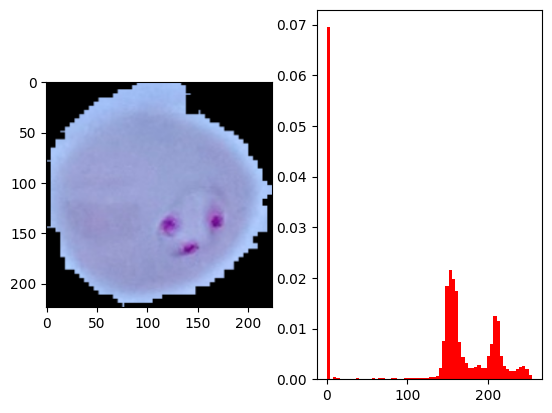

In [56]:
img = cv2.imread('FESI/Progetto/malaria/malaria/parasite (1).png')
resized = cv2.resize(img, (224, 224))

plt.subplot(1,2,1)
plt.imshow(resized)


plt.subplot(1,2,2) 
plt.hist(resized.ravel(), bins=64, density=True, color='r');


Molto probabilmente la prevalenza di tutti quei pixel = 0 è dovuta alla presenza del bordo nero (provare a rimuoverlo).
Provo a caricare un'altra immagine e a generarne l'istogramma.

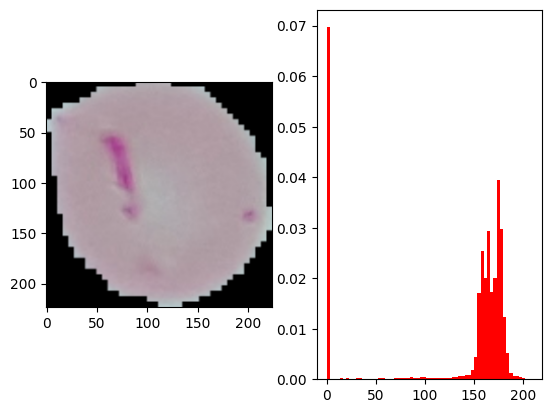

In [57]:
img2 = cv2.imread('FESI/Progetto/malaria/malaria/parasite (127).png')
resized2 = cv2.resize(img2, (224, 224)) 

plt.subplot(1,2,1)
plt.imshow(resized2)
plt.subplot(1,2,2)
plt.hist(resized2.ravel(), bins=64, density=True, color='r'); 